In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import datetime
import os
import seaborn as sns#数据可视化
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import pickle #用于存储模型
from sklearn.metrics import *
from sklearn.model_selection import *


In [2]:
train = pd.read_csv("train_users_2.csv/train_users_2.csv")
test = pd.read_csv("test_users.csv/test_users.csv")

In [3]:
print('the columns name of training dataset:\n',train.columns)
print('the columns name of test dataset:\n',test.columns)


the columns name of training dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')
the columns name of test dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')


In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [5]:
print(train.date_account_created.head())

0    2010-06-28
1    2011-05-25
2    2010-09-28
3    2011-12-05
4    2010-09-14
Name: date_account_created, dtype: object


In [6]:
print(train.date_account_created.value_counts().head())
print(train.date_account_created.value_counts().tail())

2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
Name: date_account_created, dtype: int64
2010-04-11    1
2010-03-09    1
2010-01-01    1
2010-01-31    1
2010-01-19    1
Name: date_account_created, dtype: int64


In [7]:
print(train.date_account_created.describe())

count         213451
unique          1634
top       2014-05-13
freq             674
Name: date_account_created, dtype: object


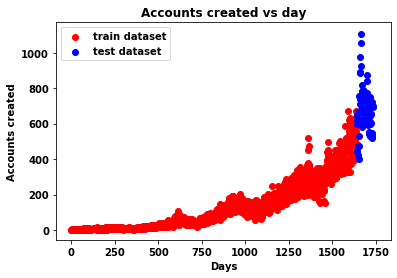

In [8]:
dac_train = train.date_account_created.value_counts()
dac_test = test.date_account_created.value_counts()
#将数据类型转换为datatime类型
dac_train_date = pd.to_datetime(train.date_account_created.value_counts().index)
dac_test_date = pd.to_datetime(test.date_account_created.value_counts().index)

#计算离首次注册时间相差的天数
dac_train_day = dac_train_date - dac_train_date.min()
dac_test_day = dac_test_date - dac_train_date.min()

#motplotlib作图
plt.scatter(dac_train_day.days, dac_train.values, color = 'r', label = 'train dataset')
plt.scatter(dac_test_day.days, dac_test.values, color = 'b', label = 'test dataset')

plt.title("Accounts created vs day")
plt.xlabel("Days")
plt.ylabel("Accounts created")
plt.legend(loc = 'upper left')

In [9]:
print(train.timestamp_first_active.head())

0    20090319043255
1    20090523174809
2    20090609231247
3    20091031060129
4    20091208061105
Name: timestamp_first_active, dtype: int64


In [10]:
print(train.timestamp_first_active.value_counts().unique())

[1]


In [11]:
tfa_train_dt = train.timestamp_first_active.astype(str).apply(lambda x:  
                                                                    datetime.datetime(int(x[:4]),
                                                                                      int(x[4:6]), 
                                                                                      int(x[6:8]), 
                                                                                      int(x[8:10]), 
                                                                                      int(x[10:12]),
                                                                                      int(x[12:])))
print(tfa_train_dt.describe())
print(tfa_train_dt.head())

count                  213451
unique                 213451
top       2013-07-01 05:26:34
freq                        1
first     2009-03-19 04:32:55
last      2014-06-30 23:58:24
Name: timestamp_first_active, dtype: object
0   2009-03-19 04:32:55
1   2009-05-23 17:48:09
2   2009-06-09 23:12:47
3   2009-10-31 06:01:29
4   2009-12-08 06:11:05
Name: timestamp_first_active, dtype: datetime64[ns]


In [12]:
print(train.date_first_booking.describe())
print(test.date_first_booking.describe())

count          88908
unique          1976
top       2014-05-22
freq             248
Name: date_first_booking, dtype: object
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: date_first_booking, dtype: float64


In [13]:
print(train.age.value_counts().head())

30.0    6124
31.0    6016
29.0    5963
28.0    5939
32.0    5855
Name: age, dtype: int64


Text(0, 0.5, 'counts')

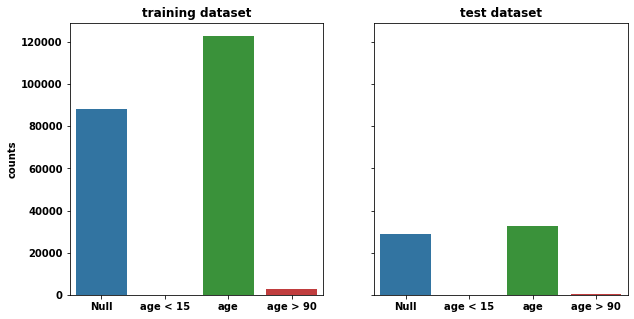

In [14]:
#首先将年龄进行分成4组missing values, too small age, reasonable age, too large age
age_train =[train[train.age.isnull()].age.shape[0],
            train.query('age < 15').age.shape[0],
            train.query("age >= 15 & age <= 90").age.shape[0],
            train.query('age > 90').age.shape[0]]

age_test = [test[test.age.isnull()].age.shape[0],
            test.query('age < 15').age.shape[0],
            test.query("age >= 15 & age <= 90").age.shape[0],
            test.query('age > 90').age.shape[0]]

columns = ['Null', 'age < 15', 'age', 'age > 90']

# plot
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey = True,figsize=(10,5))

sns.barplot(columns, age_train, ax = ax1)
sns.barplot(columns, age_test, ax = ax2)

ax1.set_title('training dataset')
ax2.set_title('test dataset')
ax1.set_ylabel('counts')

In [15]:
def feature_barplot(feature, df_train = train, df_test = test, figsize=(10,5), rot = 90, saveimg = False): 
    feat_train = df_train[feature].value_counts()
    feat_test = df_test[feature].value_counts()
    fig_feature, (axis1,axis2) = plt.subplots(1,2,sharex=True, sharey = True, figsize = figsize)
    sns.barplot(feat_train.index.values, feat_train.values, ax = axis1)
    sns.barplot(feat_test.index.values, feat_test.values, ax = axis2)
    axis1.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis2.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis1.set_title(feature + ' of training dataset')
    axis2.set_title(feature + ' of test dataset')
    axis1.set_ylabel('Counts')
    plt.tight_layout()
    if saveimg == True:
        figname = feature + ".png"
        fig_feature.savefig(figname, dpi = 75)

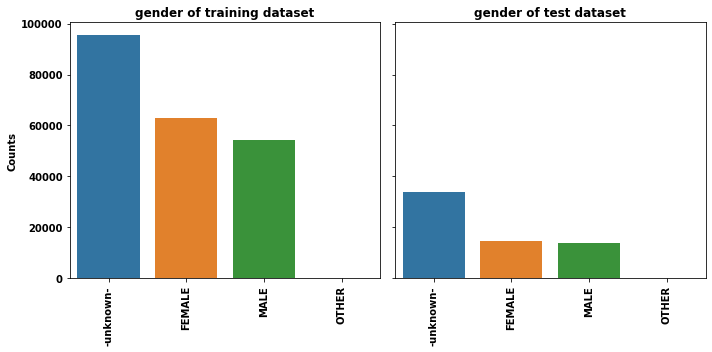

In [16]:
feature_barplot('gender', saveimg = True)

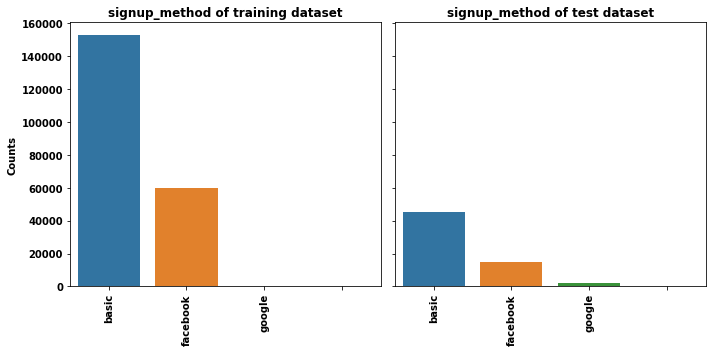

In [17]:
feature_barplot('signup_method')

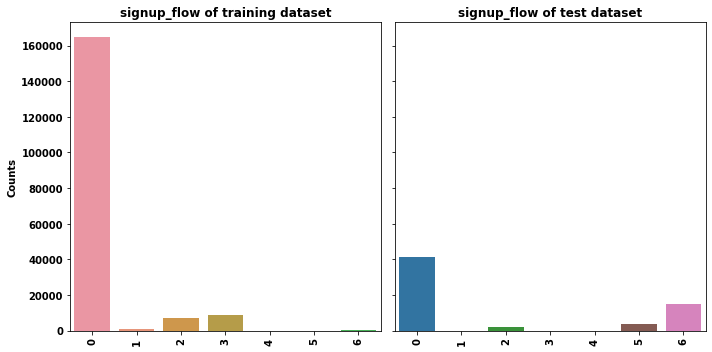

In [18]:
feature_barplot('signup_flow')

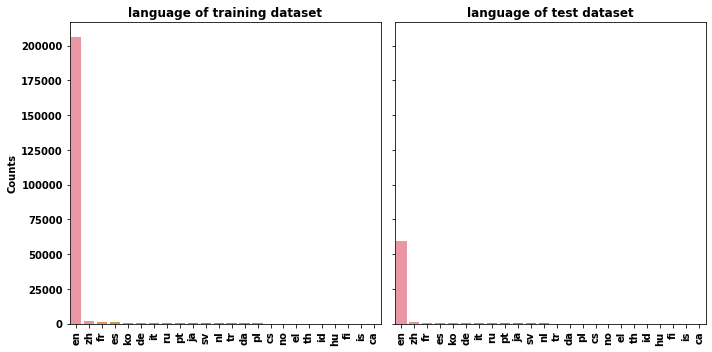

In [19]:
feature_barplot('language')

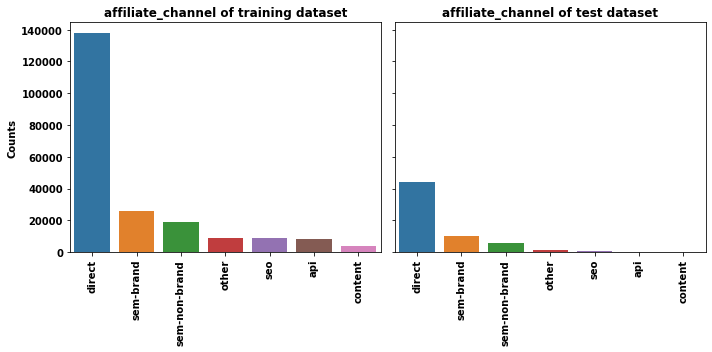

In [20]:
feature_barplot('affiliate_channel')


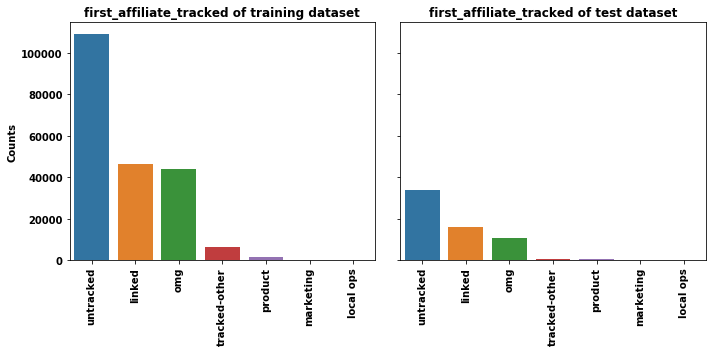

In [21]:
feature_barplot('first_affiliate_tracked')


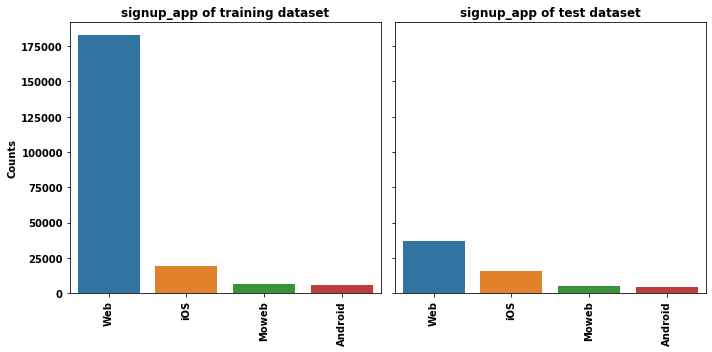

In [22]:
feature_barplot('signup_app')


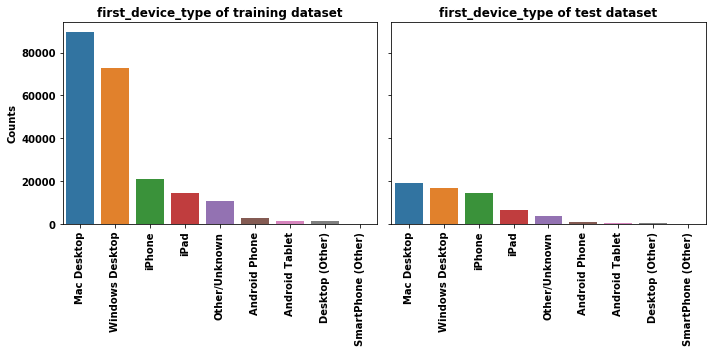

In [23]:
feature_barplot('first_device_type')


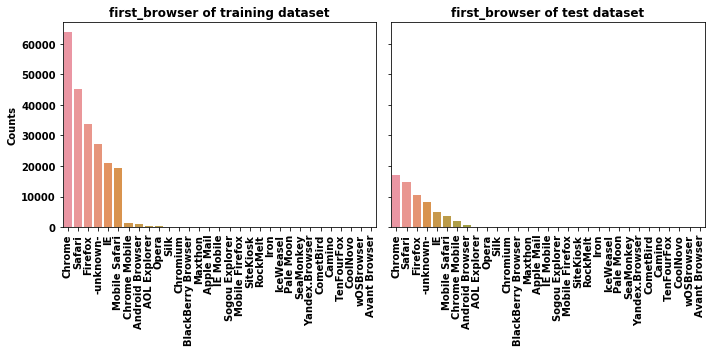

In [24]:
feature_barplot('first_browser')


In [25]:
df_sessions = pd.read_csv('sessions.csv/sessions.csv')
df_sessions.head(10)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [26]:
#这是为了后面的数据合并
df_sessions['id'] = df_sessions['user_id']
df_sessions = df_sessions.drop(['user_id'],axis=1) #按行删除
df_sessions.head()

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42
3,search_results,click,view_search_results,Windows Desktop,22141.0,d1mm9tcy42
4,lookup,NaN,NaN,Windows Desktop,435.0,d1mm9tcy42


In [27]:
df_sessions.shape


(10567737, 6)

In [28]:
df_sessions.isnull().sum()


action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
id                 34496
dtype: int64

In [29]:
df_sessions.action = df_sessions.action.fillna('NAN')
df_sessions.action_type = df_sessions.action_type.fillna('NAN')
df_sessions.action_detail = df_sessions.action_detail.fillna('NAN')
df_sessions.isnull().sum()


action                0
action_type           0
action_detail         0
device_type           0
secs_elapsed     136031
id                34496
dtype: int64

In [30]:
df_sessions.action.head()


0            lookup
1    search_results
2            lookup
3    search_results
4            lookup
Name: action, dtype: object

In [31]:
df_sessions.action.value_counts().min()


1

In [32]:
#Action values with low frequency are changed to 'OTHER'
act_freq = 100  #Threshold of frequency
act = dict(zip(*np.unique(df_sessions.action, return_counts=True)))

df_sessions.action = df_sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x)
#np.unique(df_sessions.action, return_counts=True) 取以数组形式返回非重复的action值和它的数量
#zip（*（a,b））a,b种元素一一对应，返回zip object
print(df_sessions.action.shape)

(10567737,)


In [34]:
#对action特征进行细化
f_act = df_sessions.action.value_counts().argsort()
f_act_detail = df_sessions.action_detail.value_counts().argsort()
f_act_type = df_sessions.action_type.value_counts().argsort()
f_dev_type = df_sessions.device_type.value_counts().argsort()

#按照id进行分组
dgr_sess = df_sessions.groupby(['id'])
#Loop on dgr_sess to create all the features.
samples = [] #samples列表
ln = len(dgr_sess) #计算分组后df_sessions的长度

for g in dgr_sess:  #对dgr_sess中每个id的数据进行遍历
    gr = g[1]   #data frame that comtains all the data for a groupby value 'zzywmcn0jv'
    
    l = []  #建一个空列表，临时存放特征
    
    #the id    for example:'zzywmcn0jv'
    l.append(g[0]) #将id值放入空列表中
    
    # number of total actions
    l.append(len(gr))#将id对应数据的长度放入列表
    
    #secs_elapsed 特征中的缺失值用0填充再获取具体的停留时长值
    sev = gr.secs_elapsed.fillna(0).values   #These values are used later.
    
    #action features 特征-用户行为 
    #每个用户行为出现的次数，各个行为类型的数量，平均值以及标准差
    c_act = [0] * len(f_act)
    for i,v in enumerate(gr.action.values): #i是从0-1对应的位置，v 是用户行为特征的值
        c_act[f_act[v]] += 1
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
    #计算用户行为行为特征各个类型数量的长度，平均值以及标准差
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act
    
    #action_detail features 特征-用户行为具体
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    #action_type features  特征-用户行为类型 click等
    #(how many times each value occurs, numb of unique values, mean and std
    #+ log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i] #sev = gr.secs_elapsed.fillna(0).values ，求每个行为类型总的停留时长
        c_act_type[f_act_type[v]] += 1  
    l_act_type = np.log(1 + np.array(l_act_type)).tolist() #每个行为类型总的停留时长，差异比较大，进行log处理
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    
    
    #device_type features 特征-设备类型
    #(how many times each value occurs, numb of unique values, mean and std)
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values))) 
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type    
    
    #secs_elapsed features  特征-停留时长     
    l_secs = [0] * 5 
    l_log = [0] * 15
    if len(sev) > 0:
        #Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1]) #
        
        #Values are grouped in 15 intervals. Compute the number of values
        #in each interval.
        #sev = gr.secs_elapsed.fillna(0).values 
        log_sev = np.log(1 + sev).astype(int)
        #np.bincount():Count number of occurrences of each value in array of non-negative ints.  
        l_log = np.bincount(log_sev, minlength=15).tolist()                    
    l = l + l_secs + l_log
    
    #The list l has the feature values of one sample.
    samples.append(l)

#preparing objects    
samples = np.array(samples) 
samp_ar = samples[:, 1:].astype(np.float16) #取除id外的特征数据
samp_id = samples[:, 0]   #取id，id位于第一列

#为提取的特征创建一个dataframe     
col_names = []    #name of the columns
for i in range(len(samples[0])-1):  #减1的原因是因为有个id
    col_names.append('c_' + str(i))  #起名字的方式    
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id



In [35]:
df_agg_sess.head()


,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,id
0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,6.0,2.0,3.0,3.0,1.0,0.0,1.0,0.0,00023iyk9l
1,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,12.0,2.0,8.0,4.0,3.0,0.0,0.0,0.0,0010k6l0om
2,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,30.0,9.0,8.0,1.0,0.0,0.0,0.0,0.0,001wyh0pz8
3,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,0028jgx1x1
4,789.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,111.0,102.0,104.0,57.0,28.0,9.0,4.0,1.0,1.0,002qnbzfs5


In [36]:
train = pd.read_csv("train_users_2.csv/train_users_2.csv")
test = pd.read_csv("test_users.csv/test_users.csv")
#计算出train的行数，便于之后对train和test数据进行分离操作
train_row = train.shape[0]  

# The label we need to predict
labels = train['country_destination'].values


In [37]:
train.drop(['country_destination', 'date_first_booking'], axis = 1, inplace = True)
test.drop(['date_first_booking'], axis = 1, inplace = True)


In [38]:
#连接test 和 train
df = pd.concat([train, test], axis = 0, ignore_index = True)


In [39]:
tfa = df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]),
                                                                          int(x[4:6]), 
                                                                          int(x[6:8]),
                                                                          int(x[8:10]),
                                                                          int(x[10:12]),
                                                                          int(x[12:])))


In [40]:
# create tfa_year, tfa_month, tfa_day feature
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_day'] = np.array([x.day for x in tfa])


In [41]:
#isoweekday() 可以返回一周的星期几，e.g.星期日：7；星期一：1
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa]) 
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix = 'tfa_wd')  # one hot encoding 
df = pd.concat((df, df_tfa_wd), axis = 1) #添加df['tfa_wd'] 编码后的特征
df.drop(['tfa_wd'], axis = 1, inplace = True)#删除原有未编码的特征
print(df.head())

           id date_account_created  timestamp_first_active     gender   age  \
0  gxn3p5htnn           2010-06-28          20090319043255  -unknown-   NaN   
1  820tgsjxq7           2011-05-25          20090523174809       MALE  38.0   
2  4ft3gnwmtx           2010-09-28          20090609231247     FEMALE  56.0   
3  bjjt8pjhuk           2011-12-05          20091031060129     FEMALE  42.0   
4  87mebub9p4           2010-09-14          20091208061105  -unknown-  41.0   

  signup_method  signup_flow language affiliate_channel affiliate_provider  \
0      facebook            0       en            direct             direct   
1      facebook            0       en               seo             google   
2         basic            3       en            direct             direct   
3      facebook            0       en            direct             direct   
4         basic            0       en            direct             direct   

   ... tfa_year tfa_month tfa_day tfa_wd_1  tfa_wd_2  tf

In [42]:
Y = 2000
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'

def get_season(dt):
    dt = dt.date() #获取日期
    dt = dt.replace(year=Y) #将年统一换成2000年
    return next(season for season, (start, end) in seasons if start <= dt <= end)

df['tfa_season'] = np.array([get_season(x) for x in tfa])

df_tfa_season = pd.get_dummies(df.tfa_season, prefix = 'tfa_season') # one hot encoding 
df = pd.concat((df, df_tfa_season), axis = 1)
df.drop(['tfa_season'], axis = 1, inplace = True)
print(df)

                id date_account_created  timestamp_first_active     gender  \
0       gxn3p5htnn           2010-06-28          20090319043255  -unknown-   
1       820tgsjxq7           2011-05-25          20090523174809       MALE   
2       4ft3gnwmtx           2010-09-28          20090609231247     FEMALE   
3       bjjt8pjhuk           2011-12-05          20091031060129     FEMALE   
4       87mebub9p4           2010-09-14          20091208061105  -unknown-   
...            ...                  ...                     ...        ...   
275542  cv0na2lf5a           2014-09-30          20140930235232  -unknown-   
275543  zp8xfonng8           2014-09-30          20140930235306  -unknown-   
275544  fa6260ziny           2014-09-30          20140930235408  -unknown-   
275545  87k0fy4ugm           2014-09-30          20140930235430  -unknown-   
275546  9uqfg8txu3           2014-09-30          20140930235901     FEMALE   

         age signup_method  signup_flow language affiliate_chan

In [43]:
dac = pd.to_datetime(df.date_account_created)
print(dac)

0        2010-06-28
1        2011-05-25
2        2010-09-28
3        2011-12-05
4        2010-09-14
            ...    
275542   2014-09-30
275543   2014-09-30
275544   2014-09-30
275545   2014-09-30
275546   2014-09-30
Name: date_account_created, Length: 275547, dtype: datetime64[ns]


In [44]:
# create year, month, day feature for dac

df['dac_year'] = np.array([x.year for x in dac])
df['dac_month'] = np.array([x.month for x in dac])
df['dac_day'] = np.array([x.day for x in dac])


In [45]:
# create features of weekday for dac

df['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df.dac_wd, prefix = 'dac_wd')
df = pd.concat((df, df_dac_wd), axis = 1)
df.drop(['dac_wd'], axis = 1, inplace = True)


In [46]:
# create season features fro dac

df['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(df.dac_season, prefix = 'dac_season')
df = pd.concat((df, df_dac_season), axis = 1)
df.drop(['dac_season'], axis = 1, inplace = True)


In [47]:
dt_span = dac.subtract(tfa).dt.days 

In [48]:
dt_span.value_counts().head(10)

-1     275369
 0          7
 6          4
 5          4
 1          4
 2          3
 3          3
 4          3
 28         3
 94         2
dtype: int64

In [49]:
# create categorical feature: span = -1; -1 < span < 30; 31 < span < 365; span > 365
def get_span(dt):
    # dt is an integer
    if dt == -1:
        return 'OneDay'
    elif (dt < 30) & (dt > -1):
        return 'OneMonth'
    elif (dt >= 30) & (dt <= 365):
        return 'OneYear'
    else:
        return 'other'

df['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df.dt_span, prefix = 'dt_span')
df = pd.concat((df, df_dt_span), axis = 1)
df.drop(['dt_span'], axis = 1, inplace = True)


In [50]:
df.drop(['date_account_created','timestamp_first_active'], axis = 1, inplace = True)


In [51]:
#Age 获取年龄
av = df.age.values


In [52]:
#This are birthdays instead of age (estimating age by doing 2014 - value)
#数据来自2014年，故用2014-value
av = np.where(np.logical_and(av<2000, av>1900), 2014-av, av) 
df['age'] = av


d:\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
d:\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
# Age has many abnormal values that we need to deal with. 
age = df.age
age.fillna(-1, inplace = True) #空值填充为-1
div = 15
def get_age(age):
    # age is a float number  将连续型转换为离散型
    if age < 0:
        return 'NA' #表示是空值
    elif (age < div):
        return div #如果年龄小于15岁，那么返回15岁
    elif (age <= div * 2):
        return div*2 #如果年龄大于15小于等于30岁，则返回30岁
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical' #非正常年龄


In [54]:
df['age'] = np.array([get_age(x) for x in age])
df_age = pd.get_dummies(df.age, prefix = 'age')
df = pd.concat((df, df_age), axis = 1)
df.drop(['age'], axis = 1, inplace = True)


In [55]:
feat_toOHE = ['gender', 
             'signup_method', 
             'signup_flow', 
             'language', 
             'affiliate_channel', 
             'affiliate_provider', 
             'first_affiliate_tracked', 
             'signup_app', 
             'first_device_type', 
             'first_browser']
#对其他特征进行one-hot-encoding处理
for f in feat_toOHE:
    df_ohe = pd.get_dummies(df[f], prefix=f, dummy_na=True)
    df.drop([f], axis = 1, inplace = True)
    df = pd.concat((df, df_ohe), axis = 1)


In [56]:
#将对session提取的特征整合到一起
df_all = pd.merge(df, df_agg_sess, how='left')
df_all = df_all.drop(['id'], axis=1) #删除id
df_all = df_all.fillna(-2)  #对没有sesssion data的特征进行缺失值处理

#加了一列，表示每一行总共有多少空值，这也作为一个特征
df_all['all_null'] = np.array([sum(r<0) for r in df_all.values]) 


In [57]:
Xtrain = df_all.iloc[:train_row, :]
Xtest = df_all.iloc[train_row:, :]


In [58]:
Xtrain.to_csv("Airbnb_xtrain_v2.csv")
Xtest.to_csv("Airbnb_xtest_v2.csv")
#labels.tofile（）：Write array to a file as text or binary (default)
labels.tofile("Airbnb_ytrain_v2.csv", sep='\n', format='%s') #存放目标变量


In [59]:
xtrain = pd.read_csv("Airbnb_xtrain_v2.csv",index_col=0)
ytrain = pd.read_csv("Airbnb_ytrain_v2.csv", header=None)


In [60]:
xtrain.head()


,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_448,c_449,c_450,c_451,c_452,c_453,c_454,c_455,c_456,all_null
0,2009,3,19,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
1,2009,5,23,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
2,2009,6,9,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
3,2009,10,31,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457
4,2009,12,8,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,457


In [61]:
ytrain.head()


,0
0,NDF
1,NDF
2,US
3,other
4,US


In [62]:
le = LabelEncoder()
ytrain_le = le.fit_transform(ytrain.values.ravel())


In [63]:
# Let us take 10% of the data for faster training. 
n = int(xtrain.shape[0]*0.1)
xtrain_new = xtrain.iloc[:n, :]  #训练数据
ytrain_new = ytrain_le[:n]       #训练数据的目标变量
print(xtrain_new.shape)

(21345, 661)


In [64]:
X_scaler = StandardScaler()
xtrain_new = X_scaler.fit_transform(xtrain_new)
print(xtrain_new)

[[-3.39515182 -0.89254222  0.41158123 ...  0.          0.
   0.        ]
 [-3.39515182 -0.33436011  0.87008708 ...  0.          0.
   0.        ]
 [-3.39515182 -0.05526905 -0.7346834  ...  0.          0.
   0.        ]
 ...
 [ 1.26706612 -0.61345116 -0.04692462 ...  0.          0.
   0.        ]
 [ 1.26706612 -0.61345116 -0.04692462 ...  0.          0.
   0.        ]
 [ 1.26706612 -0.61345116 -0.04692462 ...  0.          0.
   0.        ]]


In [65]:
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    
    """
     y_true : array, shape = [n_samples] #数据
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes] #预测的分数
        Predicted scores.
    k : int
    """
    
    order = np.argsort(y_score)[::-1] #分数从高到低排序, 返回下标
    y_true = np.take(y_true, order[:k]) #取出前k[0,k）个分数
    
    gain = 2 ** y_true - 1
    
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes] 
        Predicted probabilities. 预测的概率
    k : int
        Rank.
    """
    
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    scores = []
    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)
        
    return np.mean(scores)
    

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
lr = LogisticRegression(C = 1.0, penalty='l2', multi_class='ovr')
RANDOM_STATE = 2017  #随机种子

#k-fold cross validation（k-折叠交叉验证）
kf = KFold(n_splits=5, random_state=RANDOM_STATE) #分成5个组
train_score = [] 
cv_score = []

# select a k  (value how many y):
k_ndcg = 3 
# kf.split: Generate indices to split data into training and test set.
for train_index, test_index in kf.split(xtrain_new, ytrain_new):
    #训练集数据分割为训练集和测试集，y是目标变量
    X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict_proba(X_test)
    train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)
    
    train_score.append(train_ndcg_score)
    cv_score.append(cv_ndcg_score)
    
print ("\nThe training score is: {}".format(np.mean(train_score)))
print ("\nThe cv score is: {}".format(np.mean(cv_score)))


d:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
d:\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number 

d:\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

d:\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex


The training score is: 0.7594824432985814

The cv score is: 0.7441325929055068


In [67]:
# set the iterations
iteration = [1,5,10,15,20, 50, 100]

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

train_score = []
cv_score = []

# select a k:
k_ndcg = 5

for i, item in enumerate(iteration): 

    lr = LogisticRegression(C=1.0, max_iter=item, tol=1e-5, solver='newton-cg', multi_class='ovr') 
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
       
        lr.fit(X_train, y_train)

        y_pred = lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        
        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))


d:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increa

d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


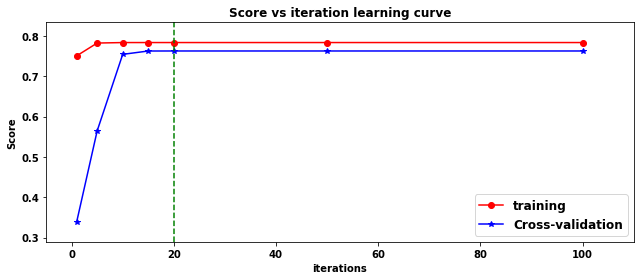

In [68]:
ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

plt.figure(figsize=(9,4))
plt.plot(iteration, train_score, 'ro-', label = 'training')
plt.plot(iteration, cv_score, 'b*-', label = 'Cross-validation')
plt.xlabel("iterations")
plt.ylabel("Score")
plt.xlim(-5, np.max(iteration)+10)
plt.ylim(ymin, ymax)
plt.plot(np.linspace(20,20,50), np.linspace(ymin, ymax, 50), 'g--')
plt.legend(loc = 'lower right', fontsize = 12)
plt.title("Score vs iteration learning curve")

plt.tight_layout()


In [69]:
# Chaning the sampling size
# set the iter to the best iteration: iter = 20

perc = [0.01,0.02,0.05,0.1,0.2,0.5,1]

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

train_score = []
cv_score = []

# select a k:
k_ndcg = 5

for i, item in enumerate(perc):
    
    lr = LogisticRegression(C=1.0, max_iter=20, tol=1e-6, solver='newton-cg', multi_class='ovr')
    train_score_iter = []
    cv_score_iter = []
    
    n = int(xtrain_new.shape[0]*item)
    xtrain_perc = xtrain_new[:n, :]
    ytrain_perc = ytrain_new[:n]


    for train_index, test_index in kf.split(xtrain_perc, ytrain_perc):
        
        X_train, X_test = xtrain_perc[train_index, :], xtrain_perc[test_index, :]
        y_train, y_test = ytrain_perc[train_index], ytrain_perc[test_index]

        print(X_train.shape, X_test.shape)
        
        lr.fit(X_train, y_train)

        y_pred = lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))
    


d:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(142, 661) (71, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(142, 661) (71, 661)
(142, 661) (71, 661)
(284, 661) (142, 661)
(284, 661) (142, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(284, 661) (142, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(711, 661) (356, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(711, 661) (356, 661)
(712, 661) (355, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(1422, 661) (712, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(1423, 661) (711, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(1423, 661) (711, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(2846, 661) (1423, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(2846, 661) (1423, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(2846, 661) (1423, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(7114, 661) (3558, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(7115, 661) (3557, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(7115, 661) (3557, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(14230, 661) (7115, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(14230, 661) (7115, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


(14230, 661) (7115, 661)


d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


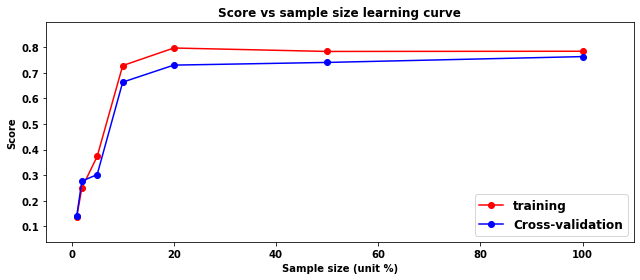

In [70]:
ymin = np.min(cv_score)-0.1
ymax = np.max(train_score)+0.1

plt.figure(figsize=(9,4))
plt.plot(np.array(perc)*100, train_score, 'ro-', label = 'training')
plt.plot(np.array(perc)*100, cv_score, 'bo-', label = 'Cross-validation')
plt.xlabel("Sample size (unit %)")
plt.ylabel("Score")
plt.xlim(-5, np.max(perc)*100+10)
plt.ylim(ymin, ymax)

plt.legend(loc = 'lower right', fontsize = 12)
plt.title("Score vs sample size learning curve")

plt.tight_layout()


In [71]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.svm import SVC, LinearSVC, NuSVC
LEARNING_RATE = 0.1
N_ESTIMATORS = 50
RANDOM_STATE = 2017
MAX_DEPTH = 9

#建了一个tree字典
clf_tree ={
    'DTree': DecisionTreeClassifier(max_depth=MAX_DEPTH,
                                    random_state=RANDOM_STATE),
    
    'RF': RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                 max_depth=MAX_DEPTH,
                                 random_state=RANDOM_STATE),
    
    'AdaBoost': AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                   learning_rate=LEARNING_RATE,
                                   random_state=RANDOM_STATE),
    
    'Bagging': BaggingClassifier(n_estimators=N_ESTIMATORS,
                                 random_state=RANDOM_STATE),
    
    'ExtraTree': ExtraTreesClassifier(max_depth=MAX_DEPTH,
                                      n_estimators=N_ESTIMATORS,
                                      random_state=RANDOM_STATE),
    
    'GraBoost': GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                           max_depth=MAX_DEPTH,
                                           n_estimators=N_ESTIMATORS,
                                           random_state=RANDOM_STATE)
}
train_score = []
cv_score = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_tree.keys():
    
    clf = clf_tree.get(key)
    
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        
        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))


d:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


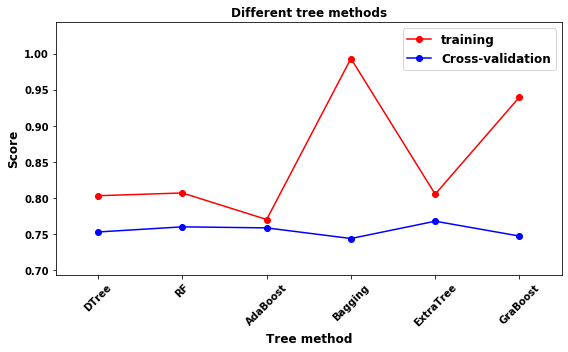

In [72]:
train_score_tree = train_score
cv_score_tree = cv_score

ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

x_ticks = clf_tree.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_tree, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_tree, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 5.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different tree methods")

plt.tight_layout()


In [73]:
TOL = 1e-4
MAX_ITER = 1000

clf_svm = {
    
    'SVM-rbf': SVC(kernel='rbf',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     
    
    'SVM-poly': SVC(kernel='poly',
                   max_iter=MAX_ITER,
                   tol=TOL, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),     
    
    'SVM-linear': SVC(kernel='linear',
                      max_iter=MAX_ITER,
                      tol=TOL, 
                      random_state=RANDOM_STATE,
                      decision_function_shape='ovr'),  
    
    'LinearSVC': LinearSVC(max_iter=MAX_ITER,
                            tol=TOL,
                            random_state=RANDOM_STATE,
                            multi_class = 'ovr')  
                            
}     

train_score_svm = []
cv_score_svm = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_svm.keys():
    
    clf = clf_svm.get(key)

    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        
        clf.fit(X_train, y_train)

        y_pred = clf.decision_function(X_test)
        train_ndcg_score = ndcg_score(y_train, clf.decision_function(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score_svm.append(np.mean(train_score_iter))
    cv_score_svm.append(np.mean(cv_score_iter))


d:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
d:\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
d:\python\python37\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
d:\python\python37\

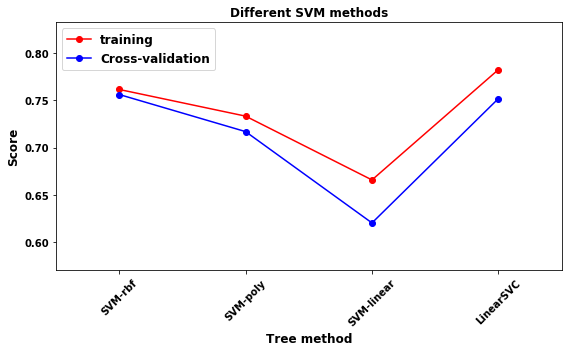

In [74]:
ymin = np.min(cv_score_svm)-0.05
ymax = np.max(train_score_svm)+0.05

x_ticks = clf_svm.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_svm, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_svm, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 3.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different SVM methods")

plt.tight_layout()


In [75]:
pip install xgboost

You should consider upgrading via the 'd:\python\python37\python.exe -m pip install --upgrade pip' command.


In [76]:
import xgboost as xgb

def customized_eval(preds, dtrain):
    labels = dtrain.get_label()
    top = []
    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])
    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score
# xgboost parameters

NUM_XGB = 200

params = {}
params['colsample_bytree'] = 0.6
params['max_depth'] = 6
params['subsample'] = 0.8
params['eta'] = 0.3
params['seed'] = RANDOM_STATE
params['num_class'] = 12
params['objective'] = 'multi:softprob'   # output the probability instead of class. 
train_score_iter = []
cv_score_iter = []

kf = KFold(n_splits = 3, random_state=RANDOM_STATE)

k_ndcg = 5

for train_index, test_index in kf.split(xtrain_new, ytrain_new):

    X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
    
    train_xgb = xgb.DMatrix(X_train, label= y_train)
    test_xgb = xgb.DMatrix(X_test, label = y_test)
    
    watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]

    bst = xgb.train(params, 
                     train_xgb,
                     NUM_XGB,
                     watchlist,
                     feval = customized_eval,
                     verbose_eval = 3,
                     early_stopping_rounds = 5)
    
    
    #bst = xgb.train( params, dtrain, num_round, evallist )

    y_pred = np.array(bst.predict(test_xgb))
    y_pred_train = np.array(bst.predict(train_xgb))
    train_ndcg_score = ndcg_score(y_train, y_pred_train , k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

    train_score_iter.append(train_ndcg_score)
    cv_score_iter.append(cv_ndcg_score)

train_score_xgb = np.mean(train_score_iter)
cv_score_xgb = np.mean(cv_score_iter)

print ("\nThe training score is: {}".format(train_score_xgb))
print ("The cv score is: {}\n".format(cv_score_xgb))


d:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0]	train-merror:0.42066	test-merror:0.50611	train-ndcg5:0.79767	test-ndcg5:0.74534
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.40836	test-merror:0.49361	train-ndcg5:0.80777	test-ndcg5:0.75244
Stopping. Best iteration:
[0]	train-merror:0.42066	test-merror:0.50611	train-ndcg5:0.79767	test-ndcg5:0.74534

[0]	train-merror:0.45144	test-merror:0.45285	train-ndcg5:0.77963	test-ndcg5:0.78126
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.43640	test-merror:0.44146	train-ndcg5:0.79151	test-ndcg5:0.78824
Stopping. Best iteration:
[0]	train-merror:0.45144	test-merror:0.45285	train-ndcg5:0.77963	test-ndcg5:0.78126

[0]	train-merror:0.43450	test-merror:0.46044	train-ndcg5:0.78943	test-ndcg5:0.76967
Multiple eval metrics have been passed: 'test-ndcg5' will be used for 